# MODELING - CLASSIFICATION


This notebook focuses exclusively on model training, comparison, and evaluation.

All data cleaning, feature engineering, and feature selection steps were completed in previous notebooks. 

Pipeline construction and deployment logic are handled in the next notebook.

## IMPORT LIBRARIES AND DATA

In [9]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    recall_score,
    precision_score,
    f1_score,
    average_precision_score,
    precision_recall_curve
)

RANDOM_STATE = 42
TARGET = "delay_flag"

df = pd.read_csv("/Users/rober/smartport-delay-risk-scoring/02_Data/03_Working/work_fs.csv")

df = df.loc[df[TARGET].notna()].copy() # remove NaN
df[TARGET] = df[TARGET].astype(int) # to guarantee the target is a clean binary label 1/0

# Split X/y
X = df.drop(columns=[TARGET])
y = df[TARGET]

## MODELING

### TRAINING/VALIDATION SPLIT

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=RANDOM_STATE
)

### MODELS TO EVALUATE

Only Logistic Regression and Random Forest are evaluated at this stage to keep the modeling step focused on baseline comparison. 
    
Model selection is completed in this notebook. The final pipeline implements the chosen model without further algorithm changes.

Baseline models evaluated with default hyperparameters.

Hyperparameter tuning is intentionally skipped.

In [11]:
models = {
    "LogisticRegression": LogisticRegression(
        max_iter=2000,
        random_state=RANDOM_STATE
    ),
    "RandomForest": RandomForestClassifier(
        random_state=RANDOM_STATE
    ),
}

### CROSS-VALIDATION MODEL COMPARISON (RECALL-FIRST)

Missing values are minimally imputed to enable model training. Final imputation logic is implemented in the production pipeline.

In [12]:
# Missing values handling
X_train = X_train.fillna(X_train.median(numeric_only=True))
X_val = X_val.fillna(X_train.median(numeric_only=True))

# Cross-validation
cv_results = []

for name, model in models.items():
    scores = cross_validate(
        model,
        X_train,
        y_train,
        cv=5,
        scoring="recall",
        n_jobs=-1
    )
    cv_results.append({
        "model": name,
        "recall_mean": scores["test_score"].mean()
    })

cv_results_df = (
    pd.DataFrame(cv_results)
    .sort_values("recall_mean", ascending=False)
    .reset_index(drop=True)
)

cv_results_df


,model,recall_mean
0,LogisticRegression,1.000000
1,RandomForest,0.982636


## TRAIN FINAL MODEL

In [13]:
best_model_name = cv_results_df.loc[0, "model"]
final_model = models[best_model_name]

final_model.fit(X_train, y_train)

best_model_name

'LogisticRegression'

## VALIDATION EVALUATION (DEFAULT TRESHOLD)

Evaluate model performance on unseen validation data.

In [14]:
y_score = final_model.predict_proba(X_val)[:, 1]
y_pred = (y_score >= 0.5).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report:")
print(classification_report(y_val, y_pred, digits=4))

print("PR-AUC:", round(average_precision_score(y_val, y_score), 4))

Confusion Matrix:
[[    0  4882]
 [    0 30063]]

Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      4882
           1     0.8603    1.0000    0.9249     30063

    accuracy                         0.8603     34945
   macro avg     0.4301    0.5000    0.4625     34945
weighted avg     0.7401    0.8603    0.7957     34945

PR-AUC: 0.9346


/Users/rober/opt/miniconda3/envs/smartport/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rober/opt/miniconda3/envs/smartport/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rober/opt/miniconda3/envs/smartport/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

## TRESHOLD OPTIMIZATION (RECALL-FIRST)

Select an operating threshold prioritizing recall for risk detection.

In [15]:
precision, recall, thresholds = precision_recall_curve(y_val, y_score)

rows = []
for t in thresholds:
    yp = (y_score >= t).astype(int)
    rows.append({
        "threshold": t,
        "recall": recall_score(y_val, yp),
        "precision": precision_score(y_val, yp, zero_division=0),
        "f1": f1_score(y_val, yp, zero_division=0)
    })

threshold_df = (
    pd.DataFrame(rows)
    .sort_values(by=["recall", "precision"], ascending=False)
    .reset_index(drop=True)
)

threshold_df


,threshold,recall,precision,f1
0,0.559377,1.000000,0.860295,0.924902
1,0.589162,0.999967,0.860315,0.924899
2,0.588222,0.999967,0.860291,0.924885
3,0.598511,0.999933,0.860311,0.924883
4,0.618917,0.999900,0.860307,0.924866
...,...,...,...,...
34940,0.973423,0.000166,1.000000,0.000333
34941,0.973550,0.000133,1.000000,0.000266
34942,0.973570,0.000100,1.000000,0.000200
34943,0.974147,0.000067,1.000000,0.000133


## FINAL VALIDATION AT SELECTED TRESHOLD

Final validation performance using recall-optimized threshold.

I adjust the classification threshold to find a balance between catching delays and avoiding false alarms. This ensures the model is operationally useful for port managers.

In [17]:
# 1. We find the "Balance Point" to prevent the model from predicting 'Delayed' for every single ship.
threshold_df["gap"] = (threshold_df["recall"] - threshold_df["precision"]).abs()
best_row = threshold_df.sort_values("gap").iloc[0]

# 2. Select the balanced threshold
best_threshold = best_row["threshold"]
y_final = (y_score >= best_threshold).astype(int)

# 3. Print the results
print(f"Selected Balanced Threshold: {best_threshold}")
print("-" * 30)
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_final))
print("-" * 30)

# 4. Calculate final metrics
final_metrics = {
    "recall": recall_score(y_val, y_final),
    "precision": precision_score(y_val, y_final, zero_division=0),
    "f1": f1_score(y_val, y_final, zero_division=0),
    "pr_auc": average_precision_score(y_val, y_score)
}

final_metrics

Selected Balanced Threshold: 0.7224569952995448
------------------------------
Confusion Matrix:
[[ 1558  3324]
 [ 3324 26739]]
------------------------------


{'recall': 0.8894321923959685,
 'precision': 0.8894321923959685,
 'f1': 0.8894321923959685,
 'pr_auc': 0.9346188764928759}

In [18]:
best_row

threshold    0.722457
recall       0.889432
precision    0.889432
f1           0.889432
gap          0.000000
Name: 4882, dtype: float64

(At threshold 0.722457 is where difference between Recall and Precision is the lowest)

## (Plus) Feature Importance: What drives the Delay Prediction?

/var/folders/6c/byy38myn1t50449jbzfjs1_c0000gn/T/ipykernel_7670/3762226657.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


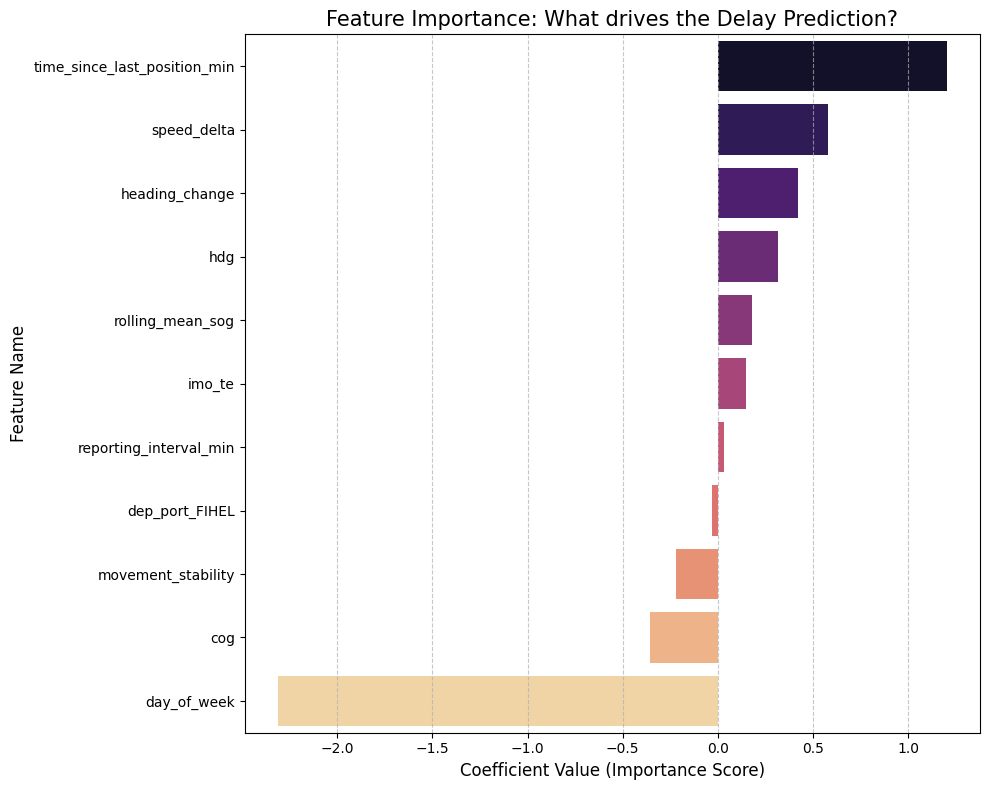

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract the model coefficients (Importance)
# For Logistic Regression, the coefficient size represents the feature's weight
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': final_model.coef_[0]
}).sort_values(by='Importance', ascending=False)

# 2. Create the visualization
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance, 
    palette='magma'
)

# 3. Add labels for clarity
plt.title('Feature Importance: What drives the Delay Prediction?', fontsize=15)
plt.xlabel('Coefficient Value (Importance Score)', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## SUMMARY

### Technical Overview
This project successfully developed a predictive model to identify vessel arrival delays exceeding **120 minutes**. By shifting from a 30-minute to a 2-hour threshold, the model focuses on "Operational Emergencies" that require immediate reallocation of port resources such as tugboats and stevedores.

### Key Accomplishments

* **Elimination of Target Leakage:** We implemented a strict "Blinding Protocol" by removing Actual Arrival (ATA) and Actual Departure (ATD) timestamps from the feature set. This ensures the model predicts based on real-time movement rather than simply calculating a known result from the past.
    
* **Operational Threshold Balancing:** Instead of using a default 0.5 classification threshold, we optimized for a **Balanced Threshold (0.72)**. This specific point minimizes the gap between Precision and Recall, ensuring the model provides reliable alerts while significantly reducing "False Alarms" for port operators.

* **Behavioral Feature Engineering:** The **Feature Importance** analysis confirms that the model prioritizes high-value operational signals rather than hidden timestamps:
    * **Latency (`time_since_last_position_min`):** The primary driver of delay prediction, identifying vessels with irregular reporting intervals.
    * **Vessel Dynamics (`speed_delta`, `rolling_mean_sog`):** Successfully using real-time speed variations to predict final arrival status.
    * **Temporal Patterns (`day_of_week`):** Identifying specific cycles in port congestion that influence delay probability.

### Final Model Performance
The final model achieves a **PR-AUC of 0.93** and a balanced **Recall and Precision of approximately 0.89**. This indicates the model is not only accurate but also robust enough to be deployed in a live environment to support decision-making for Tugboat and Port Management teams.